In [1]:
%matplotlib inline
import quandl, math
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as sm
from tsmom_model import *
import numpy as np
from datetime import datetime
token="Us3wFmXGgAj_1cUtHAAR"

import pylab
sns.set(font_scale=3)
pylab.rcParams['figure.figsize'] = (24, 18)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


tsmom_model.py:146: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  data=pd.read_csv('Price.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:148: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  qd=pd.read_csv('liquid_contracts.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='last')
tsmom_model.py:29: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).mean()
  data=pd.read_csv('Volume.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='mean')
tsmom_model.py:31: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  v=pd.read_csv('volume_data.csv',index_col=0,parse_dates=['Date']).resample(rule='d',how='sum')
tsmom_model.py:33: FutureWarning: pd.rolling_mean is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(min_periods=100,window=250,

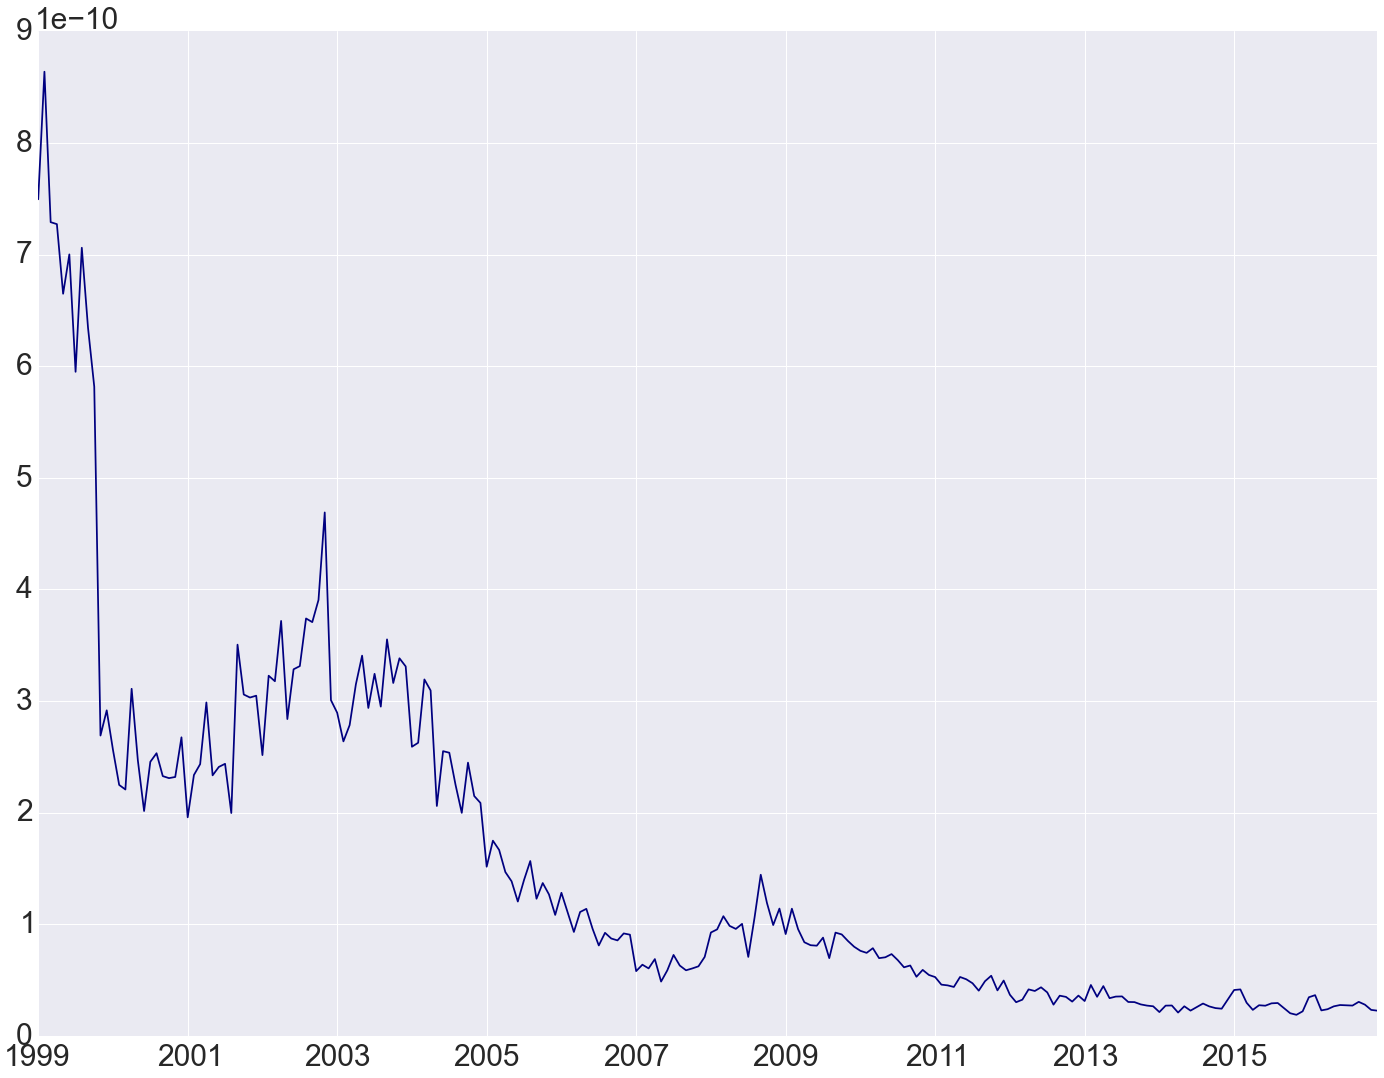

In [69]:
cleansed=load_amihud_markets_price()
amihud=calculate_amihud_liquidity(cleansed)[:'2016'] 
amihud.median(axis=1).dropna().plot(colormap='jet')

# Bank of International Settlement 
 * Turnover and Open Interest in exchange traded futures

In [144]:
futures=pd.DataFrame()
futures['OI']=quandl.get('BIS/EXCHDERIV_0',authtoken=token)['USD Billions']
futures['Turnover']=quandl.get('BIS/EXCHDERIV_32',authtoken=token)['USD Billions']

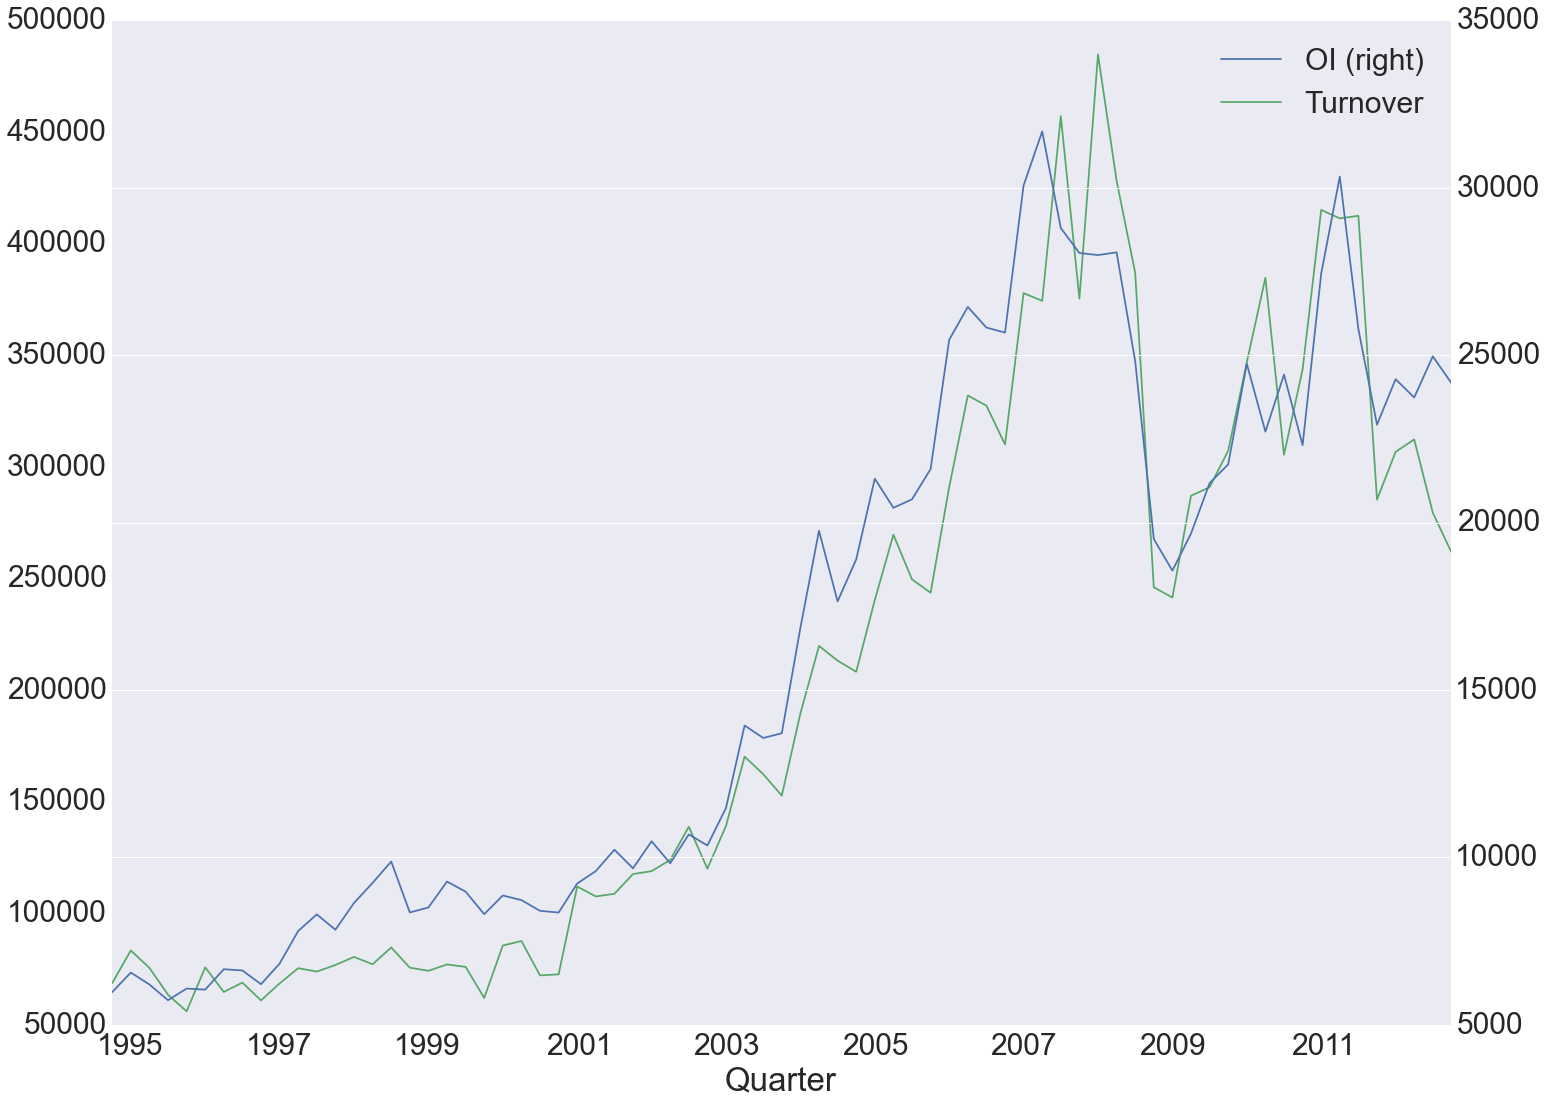

In [145]:
futures.plot(secondary_y='OI')

# Largest ETF data for Commodity 
 * Source: CRSP
 * Using the largest ETN funds that trade commodity futures to determine the rough size of the industry and see if the AUM in these ETF drive the liquidity in the market

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:7: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


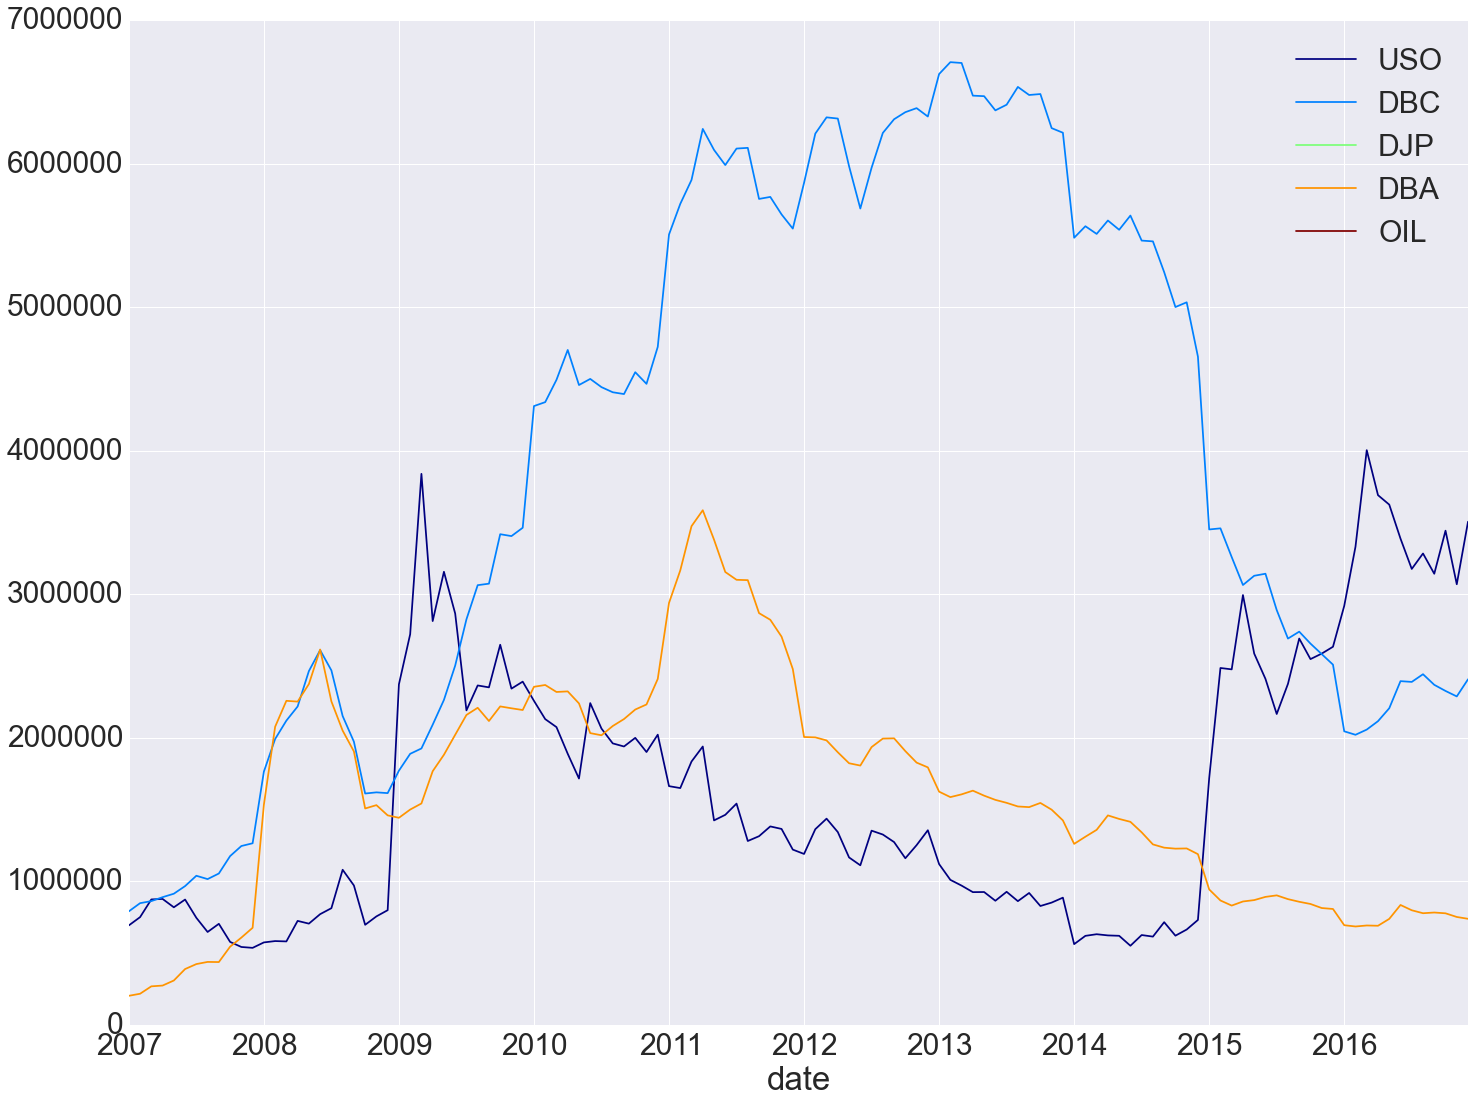

In [146]:
data=pd.read_csv('ETF_Price.csv',parse_dates=['date'])
etf_list=['USO','DBC','DJP','DBA','OIL']
etf=pd.DataFrame()
for e in etf_list:
    x=data[data.TICKER==e].set_index('date')
    etf[e]=x.PRC * x.SHROUT
etf.resample(rule='m').plot(colormap='jet')

In [147]:
mkt_liquidity=amihud.median(axis=1).dropna()
total_AUM=etf[etf_list].sum(axis=1).resample(rule='m')
ind=total_AUM[:'2016'].index
ex=pd.DataFrame()
ex['Amihud']=mkt_liquidity[ind]
ex['ETF AUM']=total_AUM[:'2016']
ex['Intercept']=1
res=sm.OLS(ex.Amihud,ex[['Intercept','ETF AUM']]).fit()

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:3: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)
  app.launch_new_instance()
/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:6: FutureWarning: .resample() is now a deferred operation
use .resample(...).mean() instead of .resample(...)


In [148]:
print res.summary()

                            OLS Regression Results                            
Dep. Variable:                 Amihud   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     12.96
Date:                Sun, 16 Jul 2017   Prob (F-statistic):           0.000466
Time:                        04:14:55   Log-Likelihood:                 2755.3
No. Observations:                 120   AIC:                            -5507.
Df Residuals:                     118   BIC:                            -5501.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   7.775e-11   7.59e-12     10.242      0.0

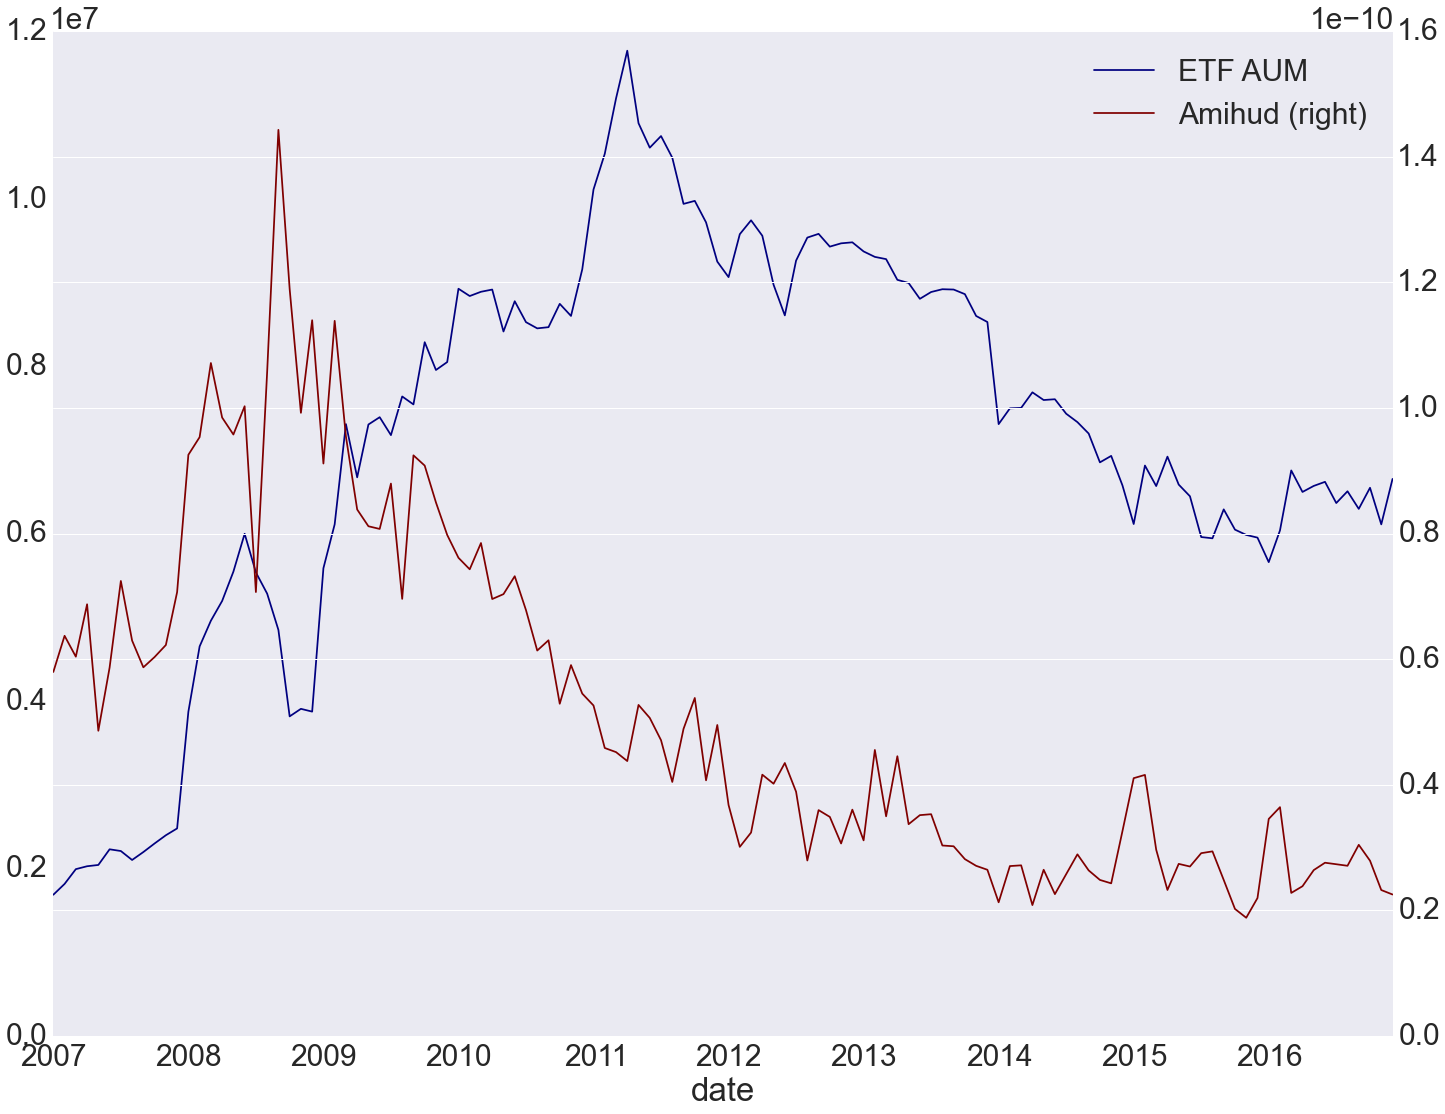

In [149]:
ex[['ETF AUM','Amihud']].plot(secondary_y='Amihud',colormap='jet')

#Hedge Fund Index
* Can Amihud explain HF performance.  For example does increased liquidity reduce the amount of returns in hedge funds


In [64]:
mkt={
    'Eurekahedge Multi–Factor Risk Premia Index':'EUREKA/MEI27',
    'Eurekahedge CTA/Managed Futures Hedge Fund Index':'EUREKA/476',
    'Eurekahedge Macro Hedge Fund Index':'EUREKA/481',
}
index=pd.DataFrame()
for k,tick in mkt.items():
    index[k]=quandl.get(tick,authtoken=token)['XXXX']
    index[k]=quandl.get(tick,authtoken=token).Returns

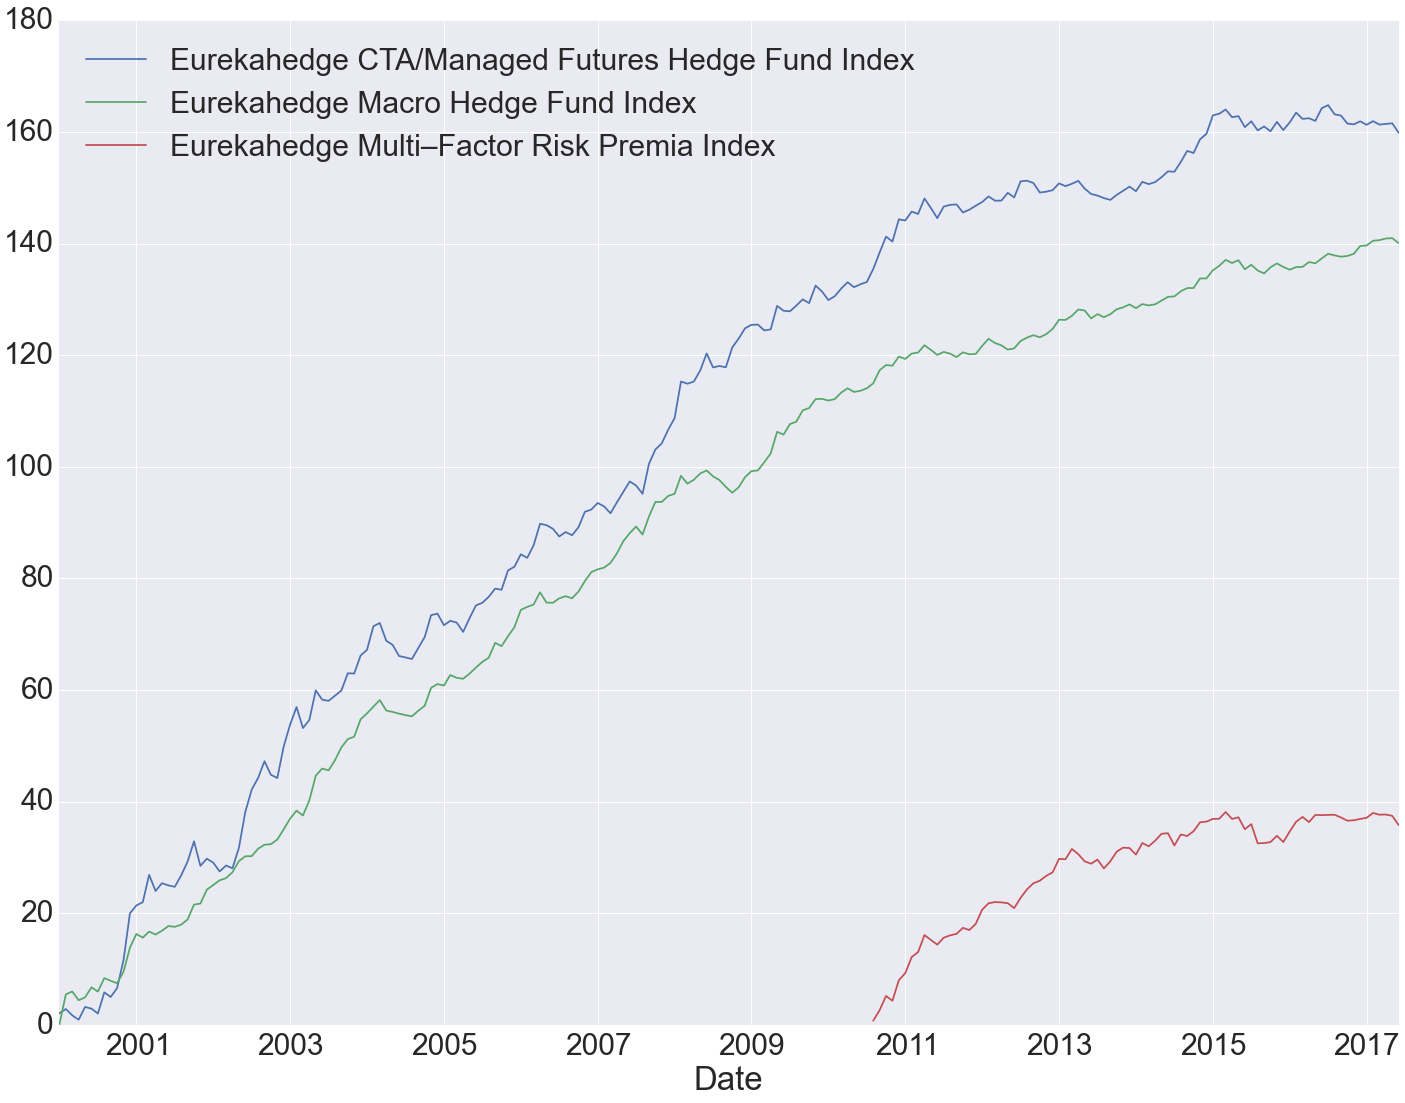

In [73]:
index.cumsum().plot()

In [135]:
mkt_liquidity=amihud.median(axis=1).dropna()
ind_res = pd.DataFrame()
for c in index.columns:
    s=pd.Series()
    ind=index[c].dropna()[:'2016'].index
    ex=pd.DataFrame()
    ex['Amihud']=mkt_liquidity[ind]
    ex['Intercept']=1
    res=sm.OLS(index[c].dropna()[ind],ex).fit()
    s['Intercept']=res.params.Intercept
    s['Intercept Tstat']=res.tvalues.Intercept
    s['Amihud']=res.params.Amihud
    s['Amihud Tstat']=res.tvalues.Amihud
    s['Adj R^2']=res.rsquared_adj
    ind_res[c]=s

In [140]:
ind_res

,Eurekahedge CTA/Managed Futures Hedge Fund Index,Eurekahedge Macro Hedge Fund Index,Eurekahedge Multi–Factor Risk Premia Index
Intercept,4.392241e-01,4.040342e-01,-4.550051e-01
Intercept Tstat,2.113648e+00,3.274272e+00,-9.406361e-01
Amihud,2.784220e+09,2.200725e+09,2.698570e+10
Amihud Tstat,2.241738e+00,2.983990e+00,2.021497e+00
Adj R^2,1.944395e-02,3.747767e-02,3.902628e-02


In [142]:
print ind_res.to_latex()

\begin{tabular}{lrrr}
\toprule
{} &  Eurekahedge CTA/Managed Futures Hedge Fund Index &  Eurekahedge Macro Hedge Fund Index &  Eurekahedge Multi–Factor Risk Premia Index \\
\midrule
Intercept       &                                      4.392241e-01 &                        4.040342e-01 &                               -4.550051e-01 \\
Intercept Tstat &                                      2.113648e+00 &                        3.274272e+00 &                               -9.406361e-01 \\
Amihud          &                                      2.784220e+09 &                        2.200725e+09 &                                2.698570e+10 \\
Amihud Tstat    &                                      2.241738e+00 &                        2.983990e+00 &                                2.021497e+00 \\
Adj R\textasciicircum2         &                                      1.944395e-02 &                        3.747767e-02 &                                3.902628e-02 \\
\bottomrule
\end{tabular}



# US 40 Act funds
* Can we use AUM of the funds to describe the increase in market liquidity
* Amihud and performance?  However, how far back does the 40 ACt fund goes

#Hedge Fund AUM
* Does increase in Hedge Fund AUM describe the rise of liquidity

Problems:
* We don't have great proxies for HFT shops

In [170]:
MF_data=pd.read_csv('MutualFund.csv',parse_dates=['caldt'])

In [171]:
MF_data.columns

Index([u'summary_period2', u'crsp_fundno', u'caldt', u'nav_latest',
       u'nav_latest_dt', u'tna_latest', u'tna_latest_dt', u'yield', u'div_ytd',
       u'cap_gains_ytd', u'unrealized_app_dep', u'unrealized_app_dt',
       u'per_com', u'per_pref', u'per_conv', u'per_corp', u'per_muni',
       u'per_govt', u'per_oth', u'per_cash', u'per_bond', u'per_abs',
       u'per_mbs', u'maturity', u'crsp_cl_grp', u'fund_name', u'nasdaq',
       u'mgmt_name', u'mgr_name', u'inst_fund', u'index_fund_flag', u'et_flag',
       u'exp_ratio', u'mgmt_fee', u'turn_ratio', u'fiscal_yearend', u'policy',
       u'lipper_class', u'lipper_class_name', u'lipper_asset_cd'],
      dtype='object')

In [184]:
MF_data[MF_data.nasdaq=='AQRIX'].T

,485619,485620,485621,485622,485623,485624,485625
summary_period2,AQ,AQ,AQ,AQ,AQ,AQ,AQ
crsp_fundno,50908,50908,50908,50908,50908,50908,50908
caldt,2010-12-31 00:00:00,2011-12-30 00:00:00,2012-12-31 00:00:00,2013-12-31 00:00:00,2014-12-31 00:00:00,2015-12-31 00:00:00,2016-12-30 00:00:00
nav_latest,10.27,10.6,11.49,10.77,10.14,9.09,9.34
nav_latest_dt,31/12/10,30/12/11,31/12/12,31/12/13,31/12/14,31/12/15,30/12/16
tna_latest,12.1,336.3,864,859,585.6,494.6,349.3
tna_latest_dt,31/12/10,30/12/11,31/12/12,31/12/13,31/12/14,31/12/15,30/12/16
yield,0.0112561,0.0201509,0.0126014,0.0252405,0.0429152,NaN,0.0251756
div_ytd,0.1156,0.2136,0.14479,0.27184,0.43516,NaN,0.23514
cap_gains_ytd,NaN,0.0028,0.47674,0.45938,0.95528,0.22835,0.42617


/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


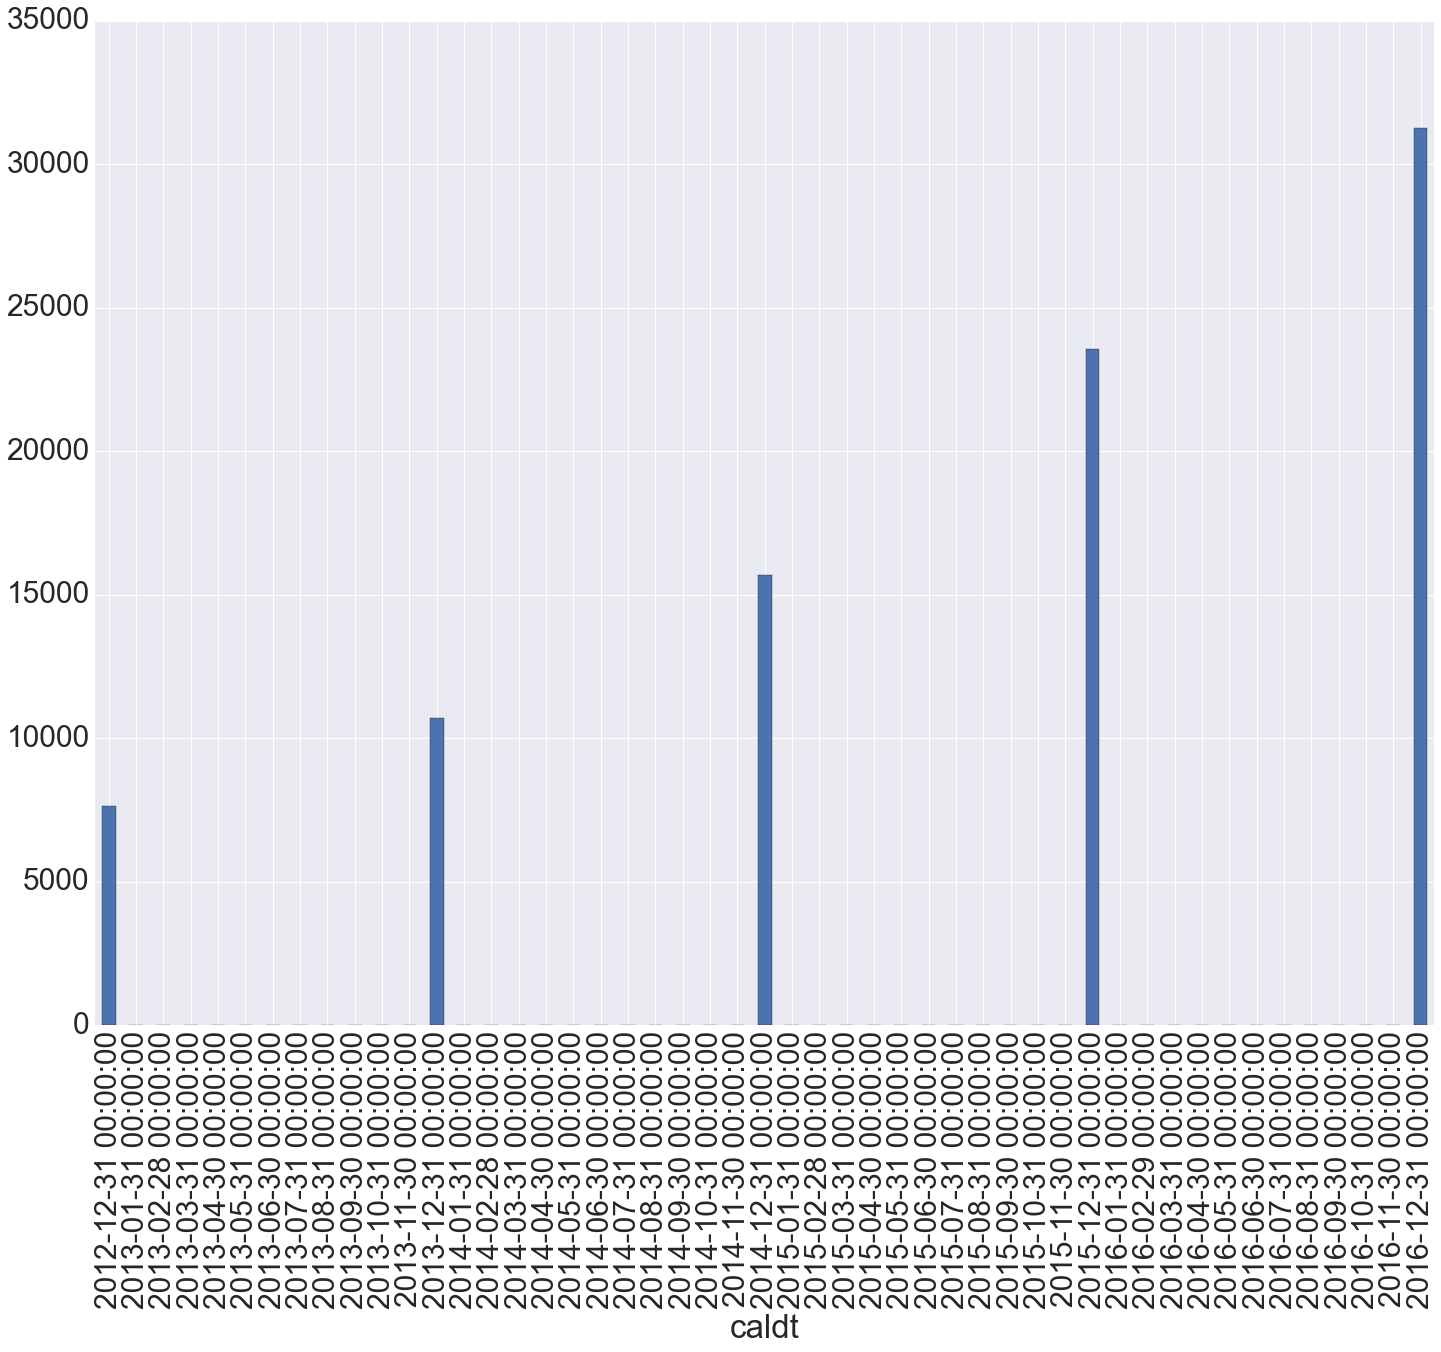

In [197]:
x=MF_data[MF_data.lipper_class=='MFF'].set_index('caldt').tna_latest.resample(rule='m',how='sum').dropna(how='all')
x.plot(kind='bar')

In [199]:
x=MF_data[MF_data.lipper_class=='GX'].set_index('caldt').tna_latest.resample(rule='m',how='sum').dropna(how='all')
x.plot(kind='bar')

/Users/mrefermat/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':


TypeError: unsupported operand type(s) for +: 'float' and 'str'